In [14]:
import sys, os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
from jax.scipy.stats.gamma import sf as gamma_sf
from jax.scipy.stats.norm import pdf as norm_pdf

import numpy as np
import scipy
import matplotlib.pyplot as plt

In [15]:
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
from lib.cgamma import c_gamma_prob, c_gamma_sf, c_multi_gamma_prob, c_multi_gamma_sf
from lib.gamma_sf_approx import gamma_sf_fast
from lib.plotting import adjust_plot_1d
from lib.network import get_network_eval_v_fn
from lib.geo import get_xyz_from_zenith_azimuth
from lib.trafos import transform_network_outputs_v, transform_network_inputs_v

In [17]:
eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/jax_reco_new/data/network')

In [21]:
n_eval = 10
dist = jnp.linspace(10, 100, n_eval)
z = -500 * jnp.ones(n_eval)
rho = 0.0 * jnp.ones(n_eval)
zenith = 1.57 * jnp.ones(n_eval)
azimuth = 3.9264083 * jnp.ones(n_eval)

x = jnp.column_stack([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs_v(x)
y = eval_network_v(x_prime)
logits, gamma_a, gamma_b = transform_network_outputs_v(y)
mix_probs = jax.nn.softmax(logits, axis=-1)

print(gamma_a)
print(gamma_b)
print(mix_probs)

[[1.17262211 3.96516712 1.00011338]
 [1.68989759 4.60147189 1.00082168]
 [2.08247489 4.80710113 1.02017744]
 [2.44311096 5.02203798 1.20713782]
 [2.73251134 5.05679516 1.41002788]
 [2.93259058 5.00797935 1.63325647]
 [3.13084711 5.03854235 1.86620249]
 [3.39655273 5.19485448 2.08953655]
 [3.70325304 5.43720561 2.29627867]
 [3.97703239 5.69424539 2.49021195]]
[[0.04314789 1.08088691 0.00230136]
 [0.03660664 0.46929101 0.00199537]
 [0.0286946  0.25508715 0.00183301]
 [0.02294991 0.15828261 0.00190515]
 [0.01810005 0.101793   0.00198738]
 [0.01386206 0.06737715 0.00205827]
 [0.0110545  0.04777288 0.00209555]
 [0.00952474 0.0366223  0.00210166]
 [0.00859615 0.02981373 0.00208604]
 [0.00782985 0.0253117  0.00205869]]
[[0.23851301 0.68635697 0.07513003]
 [0.32099187 0.52673823 0.15226991]
 [0.34524705 0.42746933 0.22728362]
 [0.36631225 0.35675031 0.27693744]
 [0.3744214  0.31603623 0.30954237]
 [0.38259418 0.30058821 0.31681761]
 [0.39733585 0.29752013 0.30514402]
 [0.41265944 0.30058954 0.

In [22]:
def c_multi_gamma_mpe_prob_pure_jax_approx(x, mix_probs, a, b, n, sigma=3.0):
    nmax = 20
    nint = 101
    eps = 1.e-6

    xmax = jnp.max(jnp.array([jnp.array(nmax * sigma), x + nmax * sigma]))
    diff = xmax-x
    xmin = jnp.max(jnp.array([jnp.array(0.0), x - diff]))

    xvals = jnp.linspace(xmin+eps, xmax, nint)
    n_pdf = norm_pdf(0.5*(xvals[:-1]+xvals[1:]), loc=x, scale=sigma)

    a_e = jnp.expand_dims(a, axis=-1)
    b_e = jnp.expand_dims(b, axis=-1)
    mix_probs_e = jnp.expand_dims(mix_probs, axis=-1)

    xvals_e = jnp.expand_dims(xvals, axis=0)
    sfs = jnp.sum(mix_probs_e * gamma_sf_fast(xvals_e, a_e, b_e), axis=0)
    sfs_power_n = jnp.power(sfs, n)
    return jnp.sum(n_pdf * (sfs_power_n[:-1]-sfs_power_n[1:]))

convolved_mpe_triple_gamma_approx_v1d_x = jax.jit(jax.vmap(c_multi_gamma_mpe_prob_pure_jax_approx, (0, None, None, None, None, None), 0))


def c_multi_gamma_mpe_prob_pure_jax(x, mix_probs, a, b, n, sigma=3.0):
    nmax = 20
    nint = 101
    eps = 1.e-6

    xmax = jnp.max(jnp.array([jnp.array(nmax * sigma), x + nmax * sigma]))
    diff = xmax-x
    xmin = jnp.max(jnp.array([jnp.array(0.0), x - diff]))

    xvals = jnp.linspace(xmin+eps, xmax, nint)
    n_pdf = norm_pdf(0.5*(xvals[:-1]+xvals[1:]), loc=x, scale=sigma)

    a_e = jnp.expand_dims(a, axis=-1)
    b_e = jnp.expand_dims(b, axis=-1)
    mix_probs_e = jnp.expand_dims(mix_probs, axis=-1)

    xvals_e = jnp.expand_dims(xvals, axis=0)
    sfs = jnp.sum(mix_probs_e * gamma_sf(xvals_e, a_e, scale=1.0/b_e), axis=0)
    sfs_power_n = jnp.power(sfs, n)
    return jnp.sum(n_pdf * (sfs_power_n[:-1]-sfs_power_n[1:]))

convolved_mpe_triple_gamma_v1d_x = jax.jit(jax.vmap(c_multi_gamma_mpe_prob_pure_jax, (0, None, None, None, None, None), 0))

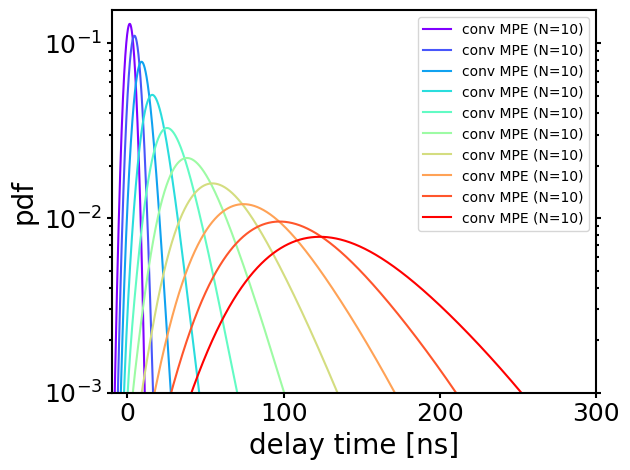

In [33]:
from matplotlib.pyplot import cm

fig, ax = plt.subplots()
xvals = np.linspace(-20, 300, 10000)

y_max = 0
n_photons = jnp.array(np.logspace(0.0, 4.0, 10))
color = cm.rainbow(np.linspace(0, 1, n_eval))

n_p = 10

for i in range(n_eval):
    ys = convolved_mpe_triple_gamma_approx_v1d_x(xvals, mix_probs[i], gamma_a[i], gamma_b[i], n_p, jnp.array(3.0))
    plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f})', color=color[i])
    y_max = np.amax([y_max, np.amax(ys)])

plot_args = {'xlim':[-10, 300],
                     'ylim':[1.e-3, 1.2*y_max],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.yscale('log')
plt.tight_layout()
plt.show()

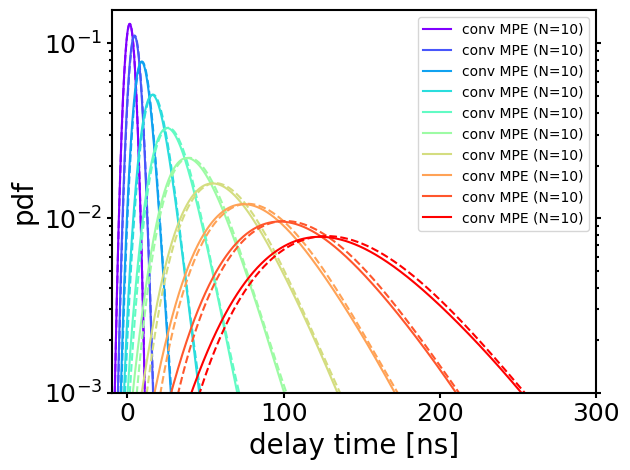

In [32]:
from matplotlib.pyplot import cm

fig, ax = plt.subplots()
xvals = np.linspace(-20, 300, 10000)

y_max = 0
n_photons = jnp.array(np.logspace(0.0, 4.0, 10))
color = cm.rainbow(np.linspace(0, 1, n_eval))

n_p = 10

for i in range(n_eval):
    ys = convolved_mpe_triple_gamma_approx_v1d_x(xvals, mix_probs[i], gamma_a[i], gamma_b[i], n_p, jnp.array(3.0))
    plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f})', color=color[i])
    y_max = np.amax([y_max, np.amax(ys)])
    ys = convolved_mpe_triple_gamma_v1d_x(xvals, mix_probs[i], gamma_a[i], gamma_b[i], n_p, jnp.array(3.0))
    plt.plot(xvals, ys, linestyle='dashed', color=color[i])
    y_max = np.amax([y_max, np.amax(ys)])

plot_args = {'xlim':[-10, 300],
                     'ylim':[1.e-3, 1.2*y_max],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.yscale('log')
plt.tight_layout()
plt.show()

In [22]:
%timeit convolved_mpe_triple_gamma_approx_v1d_x(xvals, mix_probs, gamma_a, gamma_b, 10, jnp.array(3.0)).block_until_ready()

16.4 ms ± 30.6 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
